In [3]:
import pandas as pd
%load_ext autoreload
%autoreload 1

In [4]:
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split
from src.data_loader import *
# # from src.training import *
# from src.visualization import *
# from src.evaluation import *
from sklearn.preprocessing import label_binarize
from PIL import Image
from IPython.display import Image, display
from src.pipeline import *

%aimport src.data_loader
%aimport src.visualization
%aimport src.training
%aimport src.evaluation
%aimport src.pipeline

In [7]:
data = pd.read_csv("./data/synced_dataset.csv")
# data = remove_minority_class(data)
data[["item_id", "is_cnc", "multiclass_labels"]].head()

,item_id,is_cnc,multiclass_labels
0,100033,0,5
1,100034,0,11
2,100035,1,2
3,100036,1,2
4,100040,1,2


In [15]:
data[:5000].is_cnc.value_counts(normalize=True)

is_cnc
1    0.7458
0    0.2542
Name: proportion, dtype: float64

In [15]:
features = [
            "faces", "edges", "vertices", "quantity",
            "height", "width", "depth", "volume", "area",
            "bbox_height", "bbox_width", "bbox_depth", "bbox_volume",
            "bbox_area",
        ]
train_data = data[data.binary_fold == 0].reset_index(drop=True)
X = train_data[features]
X_train, X_test, y_train_index, y_test_index = train_test_split(
            X,
            range(len(X)),
            test_size=0.2,
            random_state=42,
            stratify=train_data["is_cnc"],
        )

In [15]:
result_binary, result_multi = training_one_fold(dataset=data)

Training fold 0...
Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Training fold 6...
Training fold 7...
Training fold 8...
Training fold 9...


In [16]:
result_binary

,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9
accuracy,0.774322,0.762360,0.744817,0.754386,0.767145,0.783892,0.780702,0.789474,0.772727,0.775120
f1_macro,0.759934,0.741529,0.725581,0.736817,0.748903,0.769533,0.766913,0.774013,0.756577,0.759871
f1_weighted,0.775306,0.760722,0.744585,0.754603,0.766605,0.784580,0.781742,0.789474,0.772977,0.775699
roc_auc,0.832267,0.823100,0.817507,0.816992,0.831570,0.845355,0.844312,0.836582,0.810040,0.846106
average_precision,0.889847,0.876174,0.876118,0.869002,0.881544,0.894221,0.887809,0.881222,0.847006,0.894130


In [10]:
df_result = pd.DataFrame(result_binary)
df_result.T

,0,1
accuracy,0.774322,0.762360
f1_macro,0.759934,0.741529
f1_weighted,0.775306,0.760722
roc_auc,0.832267,0.823100
average_precision,0.889847,0.876174


In [6]:
features = [
    "faces", "edges", "vertices", "quantity",
    "height", "width", "depth", "volume", "area",
    "bbox_height", "bbox_width", "bbox_depth", "bbox_volume", "bbox_area",
]
X = data[features]


In [7]:
X_train, X_test, y_train_index, y_test_index = train_test_split(X, range(len(X)), test_size=0.2, random_state=42, stratify=data["multiclass_labels"])
y_multi_train = data["multiclass_labels"].iloc[y_train_index]
y_multi_test = data["multiclass_labels"].iloc[y_test_index]

y_binary_train = data["is_cnc"].iloc[y_train_index]
y_binary_test = data["is_cnc"].iloc[y_test_index]


params = {
    "n_estimators": randint(100, 300),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3),
}

In [8]:
best_search_multi = randomizedsearchcv_xgboost(X_train, y_multi_train, params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   2.8s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   2.4s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   2.5s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   2.7s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   2.6s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   2.6s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   2.6s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   2.7s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   2.6s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   2.5

In [9]:
# Save model to disk
joblib.dump(best_search_multi, "./models/best_model_multi.pkl")

['./models/best_model_multi.pkl']

In [10]:
best_search_binary = randomizedsearchcv_xgboost(X_train, y_binary_train, params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   0.0s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   0.0s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   0.1s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   0.1s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   0.1s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   0.1s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   0.1s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   0.1s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   0.1s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   0.1

In [11]:
# Save model to disk
joblib.dump(best_search_binary, "./models/best_model_binary.pkl")

['./models/best_model_binary.pkl']

In [12]:
# Load models from disk
best_search_multi = joblib.load("./models/best_model_multi.pkl")
best_search_binary = joblib.load("./models/best_model_binary.pkl")

# Multiclass predictions
y_multi_pred = best_search_multi.best_estimator_.predict(X_test)
y_multi_prob = best_search_multi.best_estimator_.predict_proba(X_test)

# Binary predictions
y_binary_pred = best_search_binary.best_estimator_.predict(X_test)
y_binary_prob = best_search_binary.best_estimator_.predict_proba(X_test)

In [19]:
from sklearn.metrics import roc_auc_score, average_precision_score

# Multiclass AUROC
auc_roc_multi = roc_auc_score(y_multi_test, y_multi_prob, multi_class='ovr', average='macro')

# Multiclass Average Precision
avg_precision_multi = average_precision_score(y_multi_test, y_multi_prob, average='macro')
display(auc_roc_multi, avg_precision_multi)

0.9159675993547275

0.6042723452036123

In [43]:
# Binary AUROC
auc_roc_binary = roc_auc_score(y_binary_test, y_binary_prob[:, 1])

# Binary Average Precision
avg_precision_binary = average_precision_score(y_binary_test, y_binary_prob[:, 1])
display(auc_roc_binary, avg_precision_binary)

0.9380131889158437

0.9580794635640363

In [41]:
y_binary_prob

array([[0.9459677 , 0.05403232],
       [0.04010487, 0.95989513],
       [0.04546088, 0.9545391 ],
       ...,
       [0.8093872 , 0.19061282],
       [0.01354468, 0.9864553 ],
       [0.9790657 , 0.02093427]], dtype=float32)

In [44]:
print("Multi-Class Model Evaluation")
metrics_multi = evaluate_classification(
    y_true=y_multi_test,
    y_pred=y_multi_pred,
    y_prob=y_multi_prob,
    # top_k=3
)
pprint(metrics_multi)
le = joblib.load("./models/label_encoder.pkl")
# print_classification_report(y_multi_test, y_multi_pred)

# df_multi_class_accuracy = compute_per_class_accuracy(y_multi_test, y_multi_pred, le)
# pprint(df_multi_class_accuracy)

Multi-Class Model Evaluation
{'accuracy': 0.7417630634224173,
 'average_precision': 0.6042723452036123,
 'f1_macro': 0.593230863615564,
 'f1_weighted': 0.7482129409505707,
 'roc_auc': 0.9159675993547275}


In [45]:
print("Binary Model Evaluation")
metrics_binary = evaluate_classification(
    y_true=y_binary_test,
    y_pred=y_binary_pred,
    y_prob=y_binary_prob,
)
pprint(metrics_binary)

# print_classification_report(y_binary_test, y_binary_pred)

Binary Model Evaluation
{'accuracy': 0.8742720382927802,
 'average_precision': 0.9580794635640363,
 'f1_macro': 0.8662770422115723,
 'f1_weighted': 0.8748459042431443,
 'roc_auc': 0.9380131889158437}


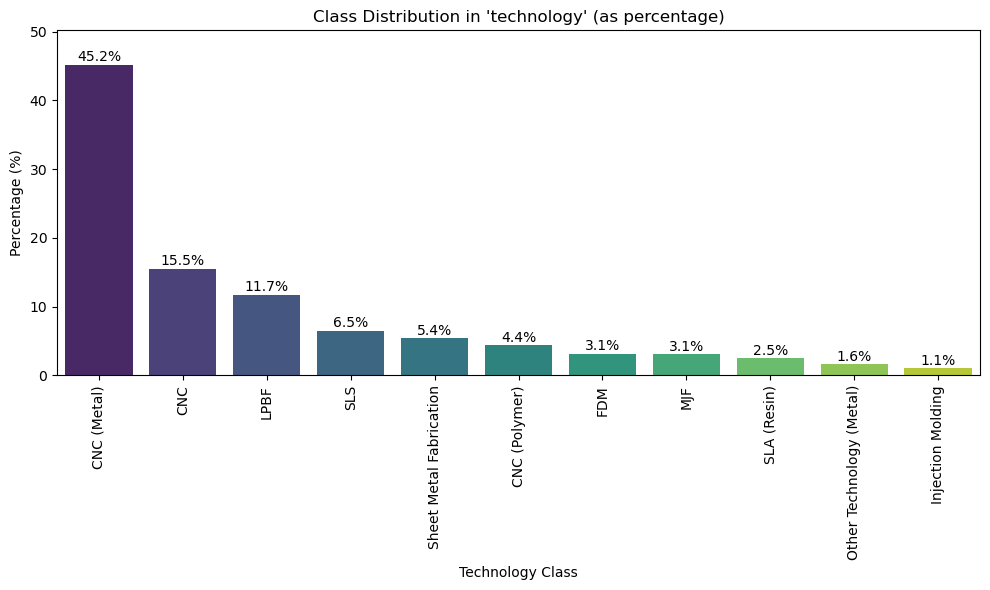

In [73]:
plot_class_distribution(data)

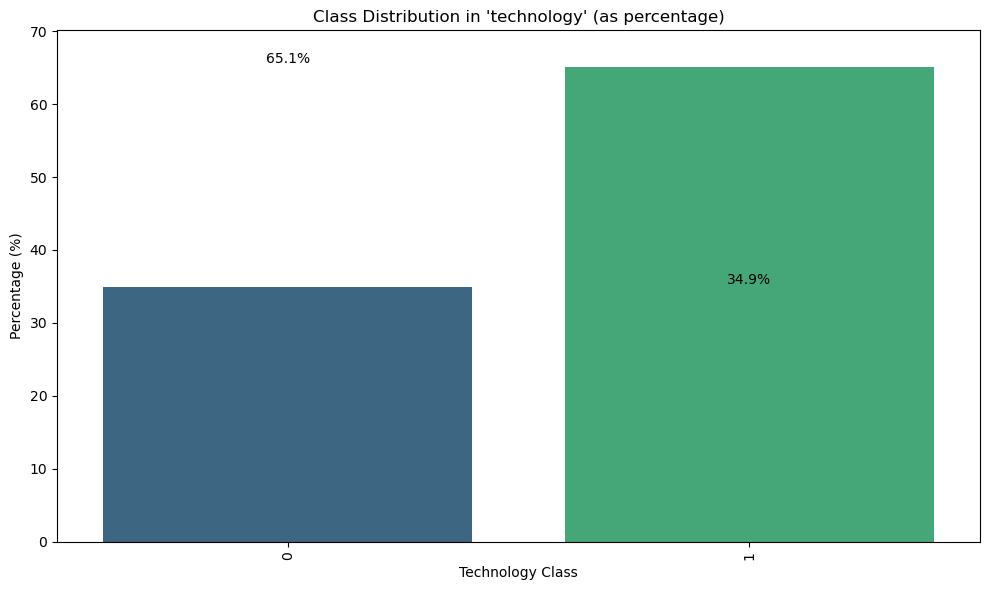

In [76]:
plot_class_distribution(data, target_col="Is_CNC")

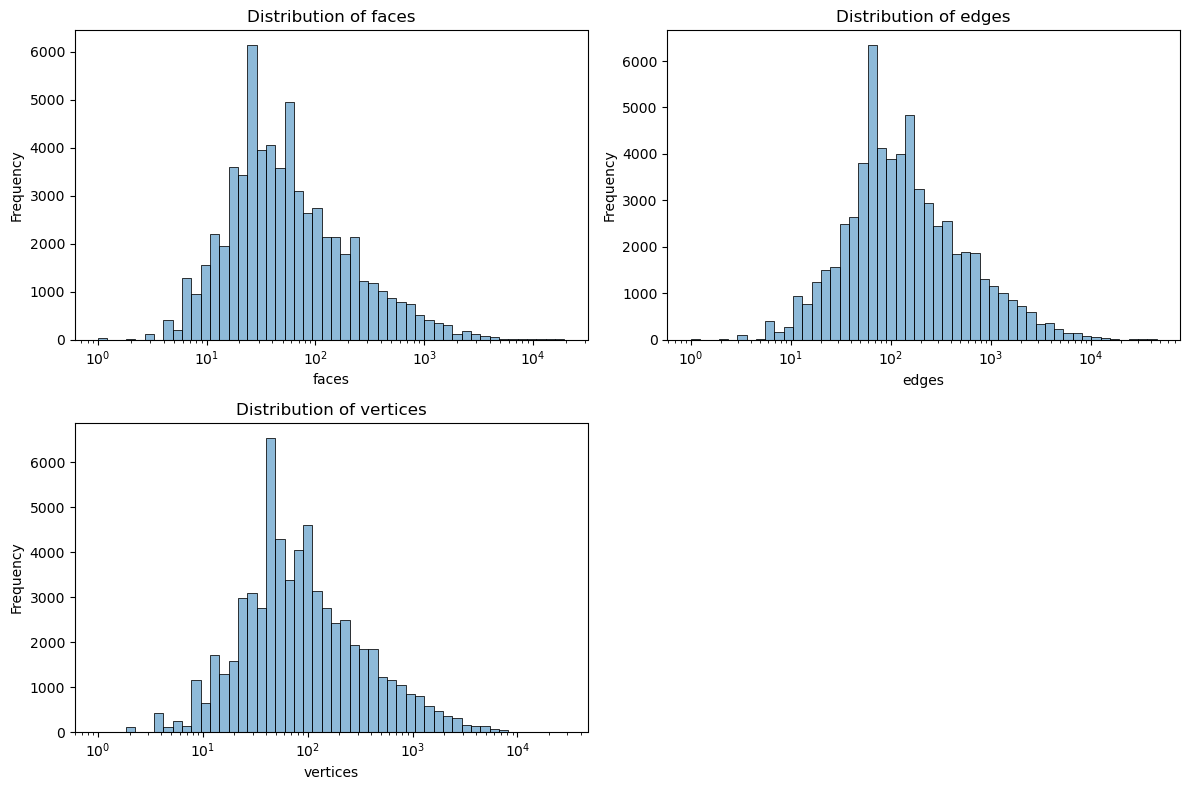

In [75]:
plot_topological_features_distribution(data, ["faces", "edges", "vertices"])

In [77]:
data.Is_CNC.value_counts()

Is_CNC
1    41019
0    21987
Name: count, dtype: int64

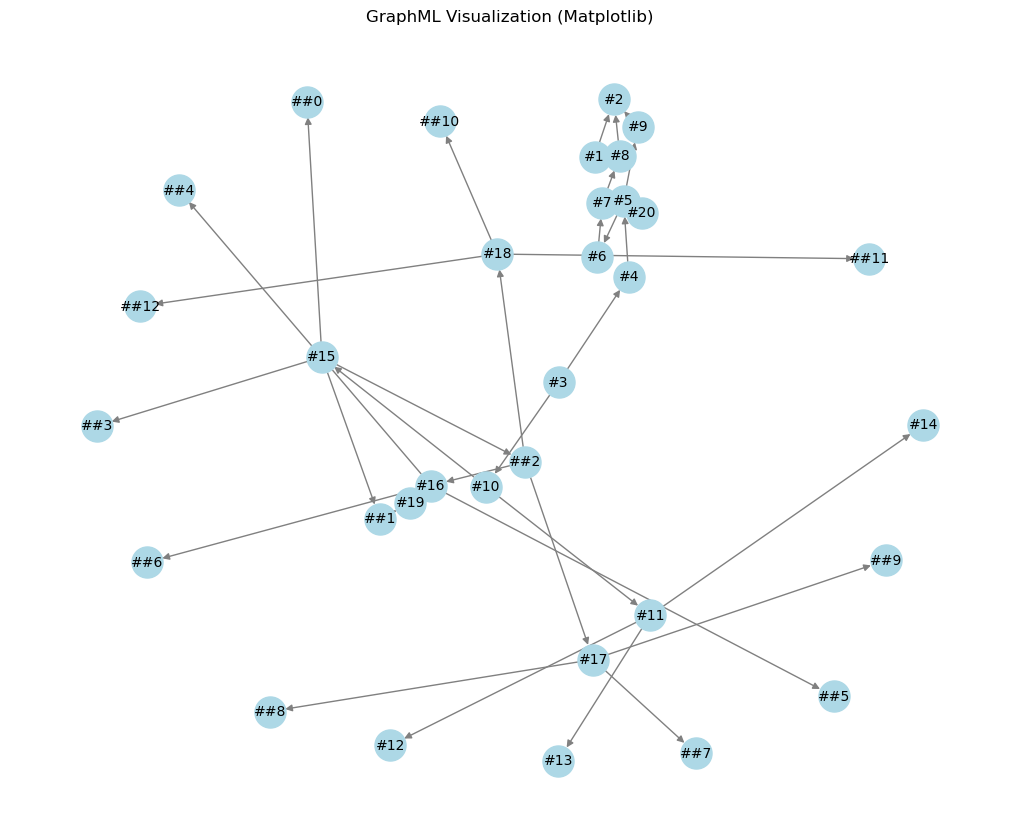

In [17]:
display_graphml_matplotlib(r"E:\gnn_data\graphml_files\119997_Thumbpick_Smaller_Right_Handed.graphml")

In [9]:
G = nx.read_graphml(r"E:\step_files_graph\square_pocket.step.graphmlsquare_pocket.graphml")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 337
Number of edges: 394


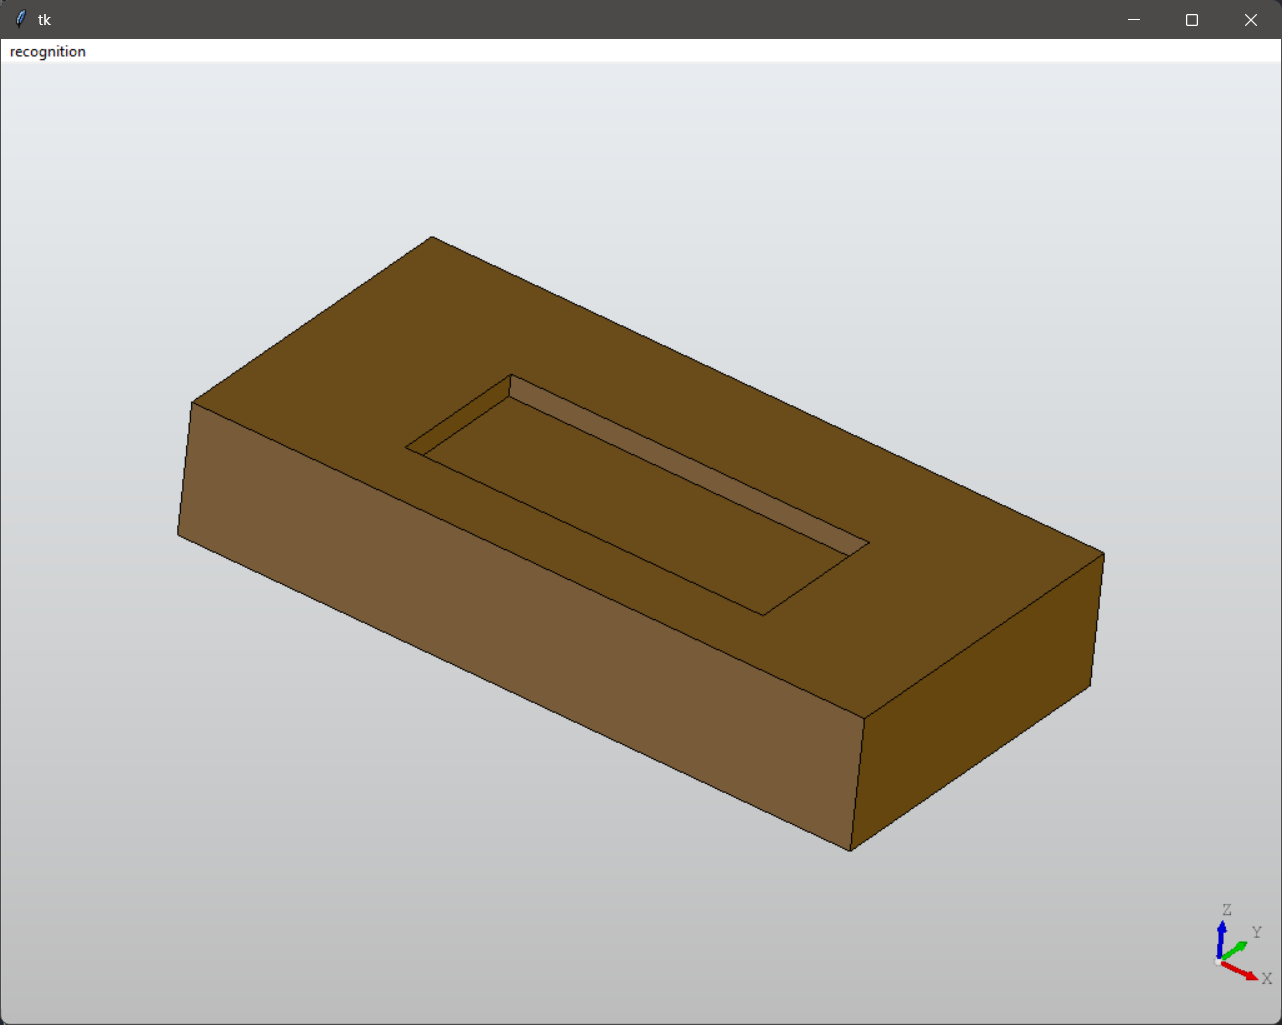

In [7]:
# display image from disk
display(Image(r"E:\2025-05-13.png"))

In [ ]:
G = nx.read_graphml(r"E:\step_files_test\square_pocket.step")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

In [31]:
df_na = df.dropna()

In [1]:
xgboost_scores = [0.83, 0.81, 0.80, 0.79, 0.82]
pointnet_scores = [0.84, 0.86, 0.83, 0.85, 0.87]
from scipy.stats import ttest_rel
ttest_rel(xgboost_scores, pointnet_scores)

TtestResult(statistic=-4.472135954999578, pvalue=0.011056493393450087, df=4)

In [5]:
data = pd.read_csv("./data/synced_dataset.csv")
data.head()

,item_id,faces,edges,vertices,file_name,depth,width,height,area,volume,...,download_file_url,technology_name,is_cnc,multiclass_labels,graphml_file,pointcloud_file,binary_fold,multiclass_fold,file_size,step_file_path
0,100033,3792.0,11286.0,7524.0,100033_Design_8.step,154.600000,66.000000,154.600000,259187.574998,854521.623711,...,https://prod-mv-user-files-upload.s3.eu-centra...,FDM,0,5,E:\gnn_data\graphml_files\100033_Design_8.graphml,E:\gnn_data\pointcloud_files\100033_Design_8.txt,7.0,5.0,7196375,E:\gnn_data\step_files\100033_Design_8.step
1,100034,568.0,1479.0,956.0,100034_5_77_v2.STEP,563.089004,98.888454,518.719571,796131.889763,912613.085344,...,https://prod-mv-user-files-upload.s3.eu-centra...,MJF,0,11,E:\gnn_data\graphml_files\100034_5_77_v2.graphml,E:\gnn_data\pointcloud_files\100034_5_77_v2.txt,1.0,5.0,8983582,E:\gnn_data\step_files\100034_5_77_v2.STEP
2,100035,216.0,637.0,423.0,100035_MakerVerse_Sample.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100035_MakerVerse_Sa...,E:\gnn_data\pointcloud_files\100035_MakerVerse...,1.0,6.0,421897,E:\gnn_data\step_files\100035_MakerVerse_Sampl...
3,100036,216.0,637.0,423.0,100036_MakerVerse_Sample.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100036_MakerVerse_Sa...,E:\gnn_data\pointcloud_files\100036_MakerVerse...,2.0,7.0,421897,E:\gnn_data\step_files\100036_MakerVerse_Sampl...
4,100040,216.0,637.0,423.0,100040_00048125_Stator_Pump.step,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100040_00048125_Stat...,E:\gnn_data\pointcloud_files\100040_00048125_S...,4.0,4.0,421899,E:\gnn_data\step_files\100040_00048125_Stator_...


In [6]:
data[data.file_name.str.startswith("23580_006")]

,item_id,faces,edges,vertices,file_name,depth,width,height,area,volume,...,download_file_url,technology_name,is_cnc,multiclass_labels,graphml_file,pointcloud_file,binary_fold,multiclass_fold,file_size,step_file_path
15886,23580,27.0,68.0,42.0,23580_006_TopCoverRFID_Magnelis_3mm_test.STEP,4.0,154.199997,184.850006,55587.419272,100869.209004,...,https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\23580_006_TopCoverRF...,E:\gnn_data\pointcloud_files\23580_006_TopCove...,0.0,2.0,59189,E:\gnn_data\step_files\23580_006_TopCoverRFID_...


In [36]:
import os

data['step_file_path'] = data['file_name'].map(lambda x: os.path.join(r"E:\gnn_data\step_files", x))


In [38]:
data['file_size'] = data['step_file_path'].map(os.path.getsize)

In [ ]:
data.head()

In [49]:
data.to_csv("./data/synced_dataset.csv", index=False)

In [32]:
data[data.file_size == 0]

,item_id,faces,edges,vertices,file_name,depth,width,height,area,volume,...,post_processing_id,download_file_url,technology_name,is_cnc,multiclass_labels,graphml_file,pointcloud_file,binary_fold,multiclass_fold,file_size
326,100498,60.0,140.0,91.0,100498_10199000001120240417_tz_extruder_victor...,148.109545,46.334813,46.03492,33365.703787,124584.383076,...,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100498_1019900000112...,E:\gnn_data\pointcloud_files\100498_1019900000...,4.0,8.0,0
